In [21]:
import scanpy as sc
import scvi
import pandas as pd

In [2]:
adata = sc.read('/lustre/scratch127/cellgen/cellgeni/shibla/cell-census/bone-marrow_cell-census.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 605318 × 60664
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'

## Integration with scVI

As a first step, we assume that the data is completely unlabelled and we wish to find common axes of variation between the two datasets. There are many methods available in scanpy for this purpose (BBKNN, Scanorama, etc.). In this notebook we present scVI. To run scVI, we simply need to:

* Register the AnnData object with the correct key to identify the sample and the layer key with the count data.
* Create an SCVI model object.

In [9]:
scvi.model.SCVI.setup_anndata(adata, batch_key="dataset_id")

In [10]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [11]:
vae.train()

/nfs/cellgeni/batu/conda-envs/scvi-env/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=13 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 13/13: 100%|██████████| 13/13 [25:15<00:00, 118.04s/it, loss=5.82e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=13` reached.


Epoch 13/13: 100%|██████████| 13/13 [25:15<00:00, 116.58s/it, loss=5.82e+03, v_num=1]


In [14]:
vae.save('/lustre/scratch127/cellgen/cellgeni/cakirb/census/model', prefix = 'bonemarrow')

---

To visualize the scVI's learned embeddings, we use the [pymde](https://pymde.org/) package wrapperin scvi-tools. This is an alternative to UMAP that is GPU-accelerated.

In [12]:
from scvi.model.utils import mde
import pymde
adata.obsm["X_mde"] = mde(adata.obsm["X_scVI"])

May 09 06:58:07 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
May 09 06:58:07 PM: The following items have duplicates [ 89015 118356 118357 ... 589943 589944 589948]


/nfs/users/nfs_b/bc8/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/nfs/users/nfs_b/bc8/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


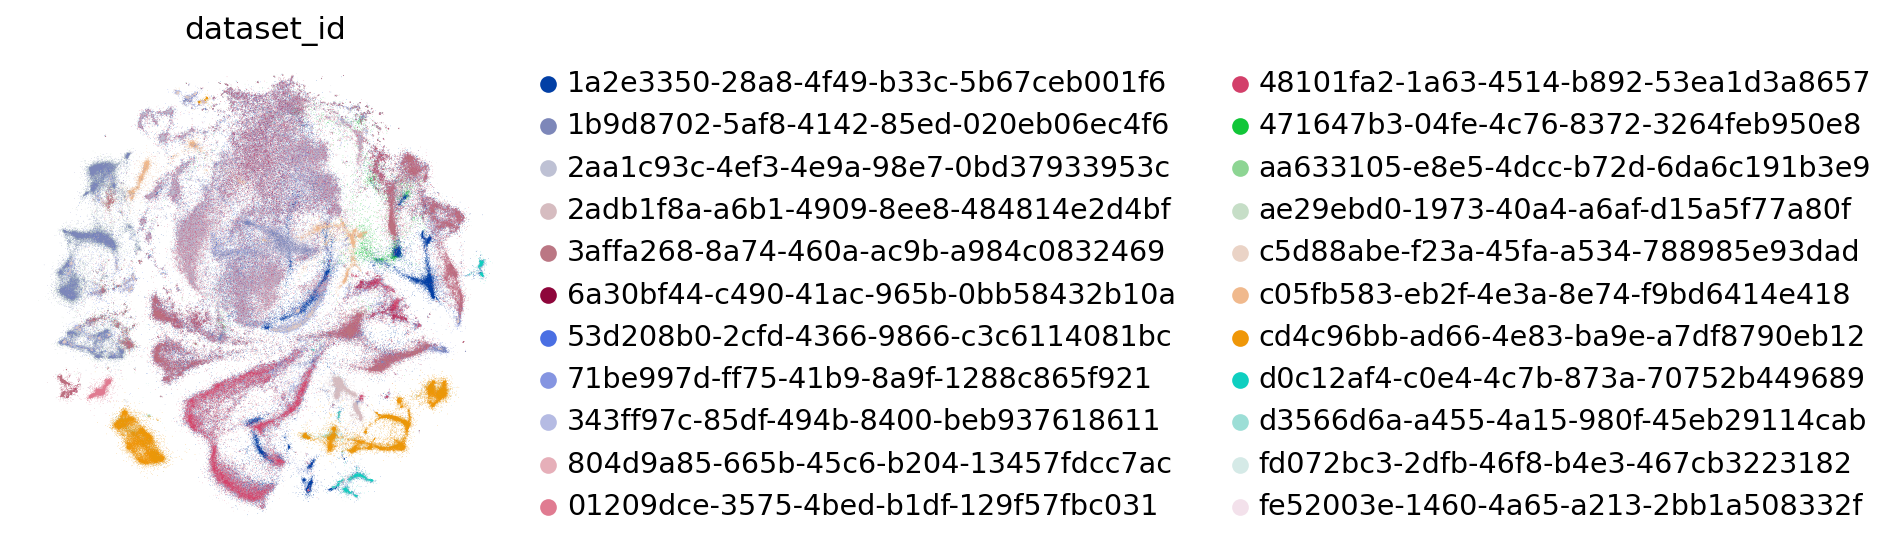

In [15]:
sc.pl.embedding(
    adata, 
    basis="X_mde",
    color=["dataset_id"], 
    frameon=False, 
    ncols=1,
)

Because this data has been used for benchmarking, we have access here to curated annotations. We can use those to assess whether the integration worked reasonably well. 

In [16]:
adata.write('/lustre/scratch127/cellgen/cellgeni/cakirb/census/bonemarrow_scvi.h5ad', compression = 'gzip')